# Tópicos Avanzados de Estadística

## Tarea: Análisis de sentimientos

### Presentado por: 
- Miguel Ángel Quintero

In [115]:
import pandas as pd
import numpy as np
# import the existing word and sentence tokenizing  
# libraries 
import nltk


# tokenizadores
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

# lematizador basado en WordNet de nltk
from nltk.stem import WordNetLemmatizer 

# steemer de nltk. Raiz de las palabras
#from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer 

import re



from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier



from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

### Primera parte: analisis de sentimientos para airlines

In [2]:
## Se trae la base de datos airlines

df_airlines = pd.read_csv('Tweets.csv')

In [3]:
df_airlines.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


####  Preprocesamiento

In [48]:
def preprocess_data(data):
    #Removes Numbers
    data = data.astype(str).str.replace('\d+', '')
    lower_text = data.str.lower()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    w_tokenizer =  TweetTokenizer(strip_handles=True, reduce_len=True)

    def lemmatize_text(text):
        return [(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize((text))]
    def remove_punctuation(words):
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', (word))
            if new_word != '':
                new_words.append(new_word)
        return new_words
    words = lower_text.apply(lemmatize_text)
    words = words.apply(remove_punctuation)
    return pd.DataFrame(words)

In [49]:
pre_tweets = preprocess_data(df_airlines['text'])
df_airlines['text_pre'] = pre_tweets

In [50]:
stop_words = set(stopwords.words('english'))
df_airlines['text_pre'] = df_airlines['text_pre'].apply(lambda x: [item for item in x if item not in stop_words])

In [59]:
# Como se realiza una clasificación binaria, es necesario eliminar los tweets considerados como neutros

df_airlines = df_airlines[df_airlines['airline_sentiment']!='neutral']

In [94]:
df_airlines['text_pre'] = df_airlines['text_pre'].apply(lambda x: " ".join(x))

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [95]:
## Se crea la variable TARGET

df_airlines['TARGET'] = np.where(df_airlines['airline_sentiment']=='positive', 1, 0)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [96]:
# se crean las variables de entrenamiento y prueba:
X_train, X_test , y_train, y_test = train_test_split(df_airlines['text_pre'],df_airlines['TARGET'].values, test_size=0.2,stratify=df_airlines['TARGET'].values)

In [101]:
vectorizador = TfidfVectorizer()
X_train_s = vectorizador.fit_transform(X_train)
X_test_s = vectorizador.transform(X_test)

In [119]:
metrics_values = {}

#### 1. Regresión logistica

In [120]:
lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
lr.fit(X_train_s,y_train)
y_pred = lr.predict(X_test_s)

acc = round(metrics.accuracy_score(y_test,y_pred),3)
f1 = round(metrics.f1_score(y_test, y_pred),3)
metrics_values['Regresión Logistica'] = [acc,f1]

print("Accuracy: ",acc)
print("F1: ",f1)

Accuracy:  0.9
F1:  0.699


#### 2. Naive Bayes

In [121]:
nb = GaussianNB()
nb.fit(X_train_s.toarray(),y_train)
y_pred = nb.predict(X_test_s.toarray())

acc = round(metrics.accuracy_score(y_test,y_pred),3)
f1 = round(metrics.f1_score(y_test, y_pred),3)
metrics_values['Naive Bayes'] = [acc,f1]

print("Accuracy: ",acc)
print("F1: ",f1)

Accuracy:  0.685
F1:  0.476


#### 3. Support Vector Machine (SVM)

In [122]:
svm_linear = svm.SVC(kernel='linear')
svm_linear.fit(X_train_s.toarray(),y_train)
y_pred = svm_linear.predict(X_test_s.toarray())

acc = round(metrics.accuracy_score(y_test,y_pred),3)
f1 = round(metrics.f1_score(y_test, y_pred),3)
metrics_values['SVM'] = [acc,f1]

print("Accuracy: ",acc)
print("F1: ",f1)

Accuracy:  0.919
F1:  0.782


#### 4. red neuronal

In [138]:
tweet = X_train
tweet_test = X_test
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweet)
vocab_size = len(tokenizer.word_index) + 1

encoded_docs_train = tokenizer.texts_to_sequences(tweet)
encoded_docs_test = tokenizer.texts_to_sequences(tweet_test)
padded_sequence_train = pad_sequences(encoded_docs_train, maxlen=200)
padded_sequence_test = pad_sequences(encoded_docs_test, maxlen=200)

In [139]:
embedding_vector_length = 32
model = Sequential() 
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(model.summary()) 

history = model.fit(padded_sequence_train,y_train,validation_split=0.2, epochs=5, batch_size=32)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 32)           286816    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 200, 32)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 303,467
Trainable params: 303,467
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
231/231 [==============================] - 58s 241ms/step - loss: 0.4369 - accuracy: 0.8175 - val_l

In [147]:
y_pred = model.predict(padded_sequence_test)
y_pred

array([[4.5858920e-03],
       [5.0507188e-03],
       [7.6136243e-01],
       ...,
       [9.7342700e-01],
       [2.1302700e-04],
       [3.4238803e-01]], dtype=float32)

In [141]:
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [153]:
accuracy, f1_score= model.evaluate(padded_sequence_test, y_test, verbose=0)
y_pred_bool = np.argmax(y_pred, axis=1)
accuracy = round(metrics.accuracy_score(y_test,y_pred_bool),3)

metrics_values['Red Neuronal'] = [accuracy,f1_score]

print("Accuracy: ",accuracy)
print("F1: ",f1_score)

Accuracy:  0.795
F1:  0.9107838869094849


#### 5. Compare los resultados

In [160]:
results = pd.DataFrame(metrics_values,index=['accuracy','f1-score'])

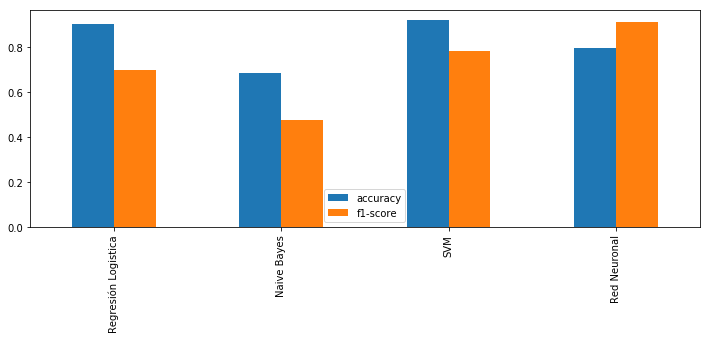

In [170]:
results.T.plot(kind='bar',figsize=(12,4))

#### 6. Usando los datos sentiment140 dataset con el modelo que más me convenga

In [173]:
df = pd.read_csv(r'training.1600000.processed.noemoticon.csv',encoding="ISO-8859-1")

In [174]:
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [176]:
columns = ['TARGET','ID','FECHA','QUERY','NAME','text']
df.columns=columns

In [178]:
df.TARGET.value_counts()

4    800000
0    799999
Name: TARGET, dtype: int64

Se vuelve a realizar todo el preprocesamiento

In [180]:
pre_tweets = preprocess_data(df['text'])
df['text_pre'] = pre_tweets

In [181]:
stop_words = set(stopwords.words('english'))
df['text_pre'] = df['text_pre'].apply(lambda x: [item for item in x if item not in stop_words])

In [182]:
df['text_pre'] = df['text_pre'].apply(lambda x: " ".join(x))

In [187]:
df.loc[df['TARGET']==4,'TARGET']=1

In [189]:
# se crean las variables de entrenamiento y prueba:
X_train, X_test , y_train, y_test = train_test_split(df['text_pre'],df['TARGET'].values, test_size=0.2,stratify=df['TARGET'].values)

In [197]:
vectorizador = TfidfVectorizer()
X_train_s = vectorizador.fit_transform(X_train)
X_test_s = vectorizador.transform(X_test)

Como el mejor modelo en un equilibrio entre métricas y costo computacional fue la regresión logistica, se aplicará sobre este caso.

In [196]:
lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
lr.fit(X_train_s,y_train)
y_pred = lr.predict(X_test_s)

acc = round(metrics.accuracy_score(y_test,y_pred),3)
f1 = round(metrics.f1_score(y_test, y_pred),3)
metrics_values['Regresión Logistica'] = [acc,f1]

print("Accuracy: ",acc)
print("F1: ",f1)

Accuracy:  0.785
F1:  0.788
